In [42]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import os
import time

import numpy as np
import pandas as pd
import json
import glob
import seaborn as sns
from PIL import Image

from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization,Flatten, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import to_categorical
from PIL import Image

tf.__version__

'2.1.0'

In [48]:
train_dir = "/Users/yash9/Documents/Projects/captcha-tensorflow/datasets/char-4-epoch-40/train" 
h, w, c = 100, 120, 3
N_LABELS = 10
DIGITS = 4

In [49]:
#creating a function for parsing the filepath and extract captcha

def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [50]:
# make a dataframe of the files

#first make a list
files = glob.glob(os.path.join(train_dir, "*.png"))
attributes = list(map(parse_filepath, files))


In [51]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label','file']
df = df.dropna()
df.head()

,label,file
0,0123,/Users/yash9/Documents/Projects/captcha-tensor...
1,0123,/Users/yash9/Documents/Projects/captcha-tensor...
2,0123,/Users/yash9/Documents/Projects/captcha-tensor...
3,0123,/Users/yash9/Documents/Projects/captcha-tensor...
4,0123,/Users/yash9/Documents/Projects/captcha-tensor...


In [52]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 98784, valid count: 42336, test count: 60480


In [53]:
def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(int(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [54]:
my_model = Sequential()

my_model.add(Input(shape=(h, w, c))) 
my_model.add(Conv2D(32,(3,3), activation = "relu"))
my_model.add(MaxPool2D((2,2)))

my_model.add(Conv2D(64,(3,3), activation = "relu"))
my_model.add(MaxPool2D((2,2)))

my_model.add(Conv2D(128,(3,3), activation = "relu"))
my_model.add(MaxPool2D((2,2)))


my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))

my_model.add(Dense(DIGITS*N_LABELS, activation='softmax'))
my_model.add(Reshape((DIGITS,N_LABELS)))

my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'])

my_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 118, 32)       896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 59, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 28, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 13, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16640)            

In [55]:
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = my_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1543 steps, validate for 661 steps
Epoch 1/5
1543/1543 [==============================] - 193s 125ms/step - loss: 0.6915 - accuracy: 0.7680 - val_loss: 0.2284 - val_accuracy: 0.9291
Epoch 2/5
1543/1543 [==============================] - 150s 97ms/step - loss: 0.1576 - accuracy: 0.9497 - val_loss: 0.1201 - val_accuracy: 0.9619
Epoch 3/5
1543/1543 [==============================] - 164s 107ms/step - loss: 0.0857 - accuracy: 0.9729 - val_loss: 0.1119 - val_accuracy: 0.9649
Epoch 4/5
1543/1543 [==============================] - 182s 118ms/step - loss: 0.0587 - accuracy: 0.9812 - val_loss: 0.0963 - val_accuracy: 0.9705
Epoch 5/5
1543/1543 [==============================] - 173s 112ms/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.0832 - val_accuracy: 0.9748


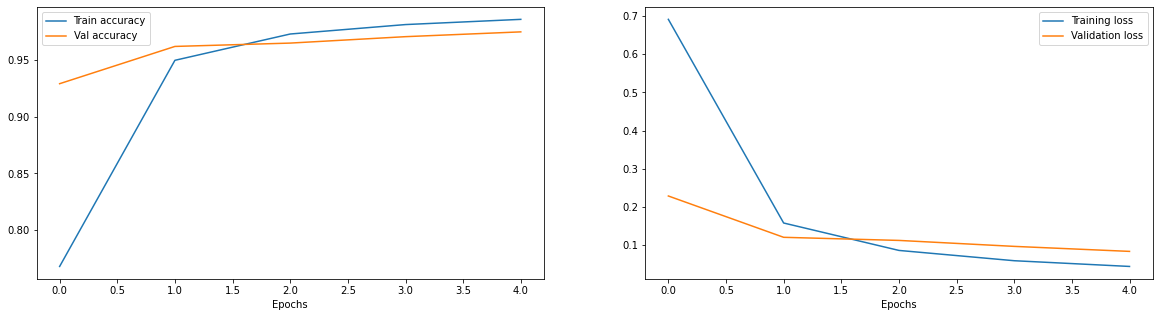

In [56]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [57]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(my_model.metrics_names, my_model.evaluate(test_gen, steps=len(test_idx)//128)))

  ...
    to  
  ['...']
472/472 [==============================] - 88s 186ms/step - loss: 0.0845 - accuracy: 0.9751


{'loss': 0.08454766203412566, 'accuracy': 0.9750687}

In [58]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = my_model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

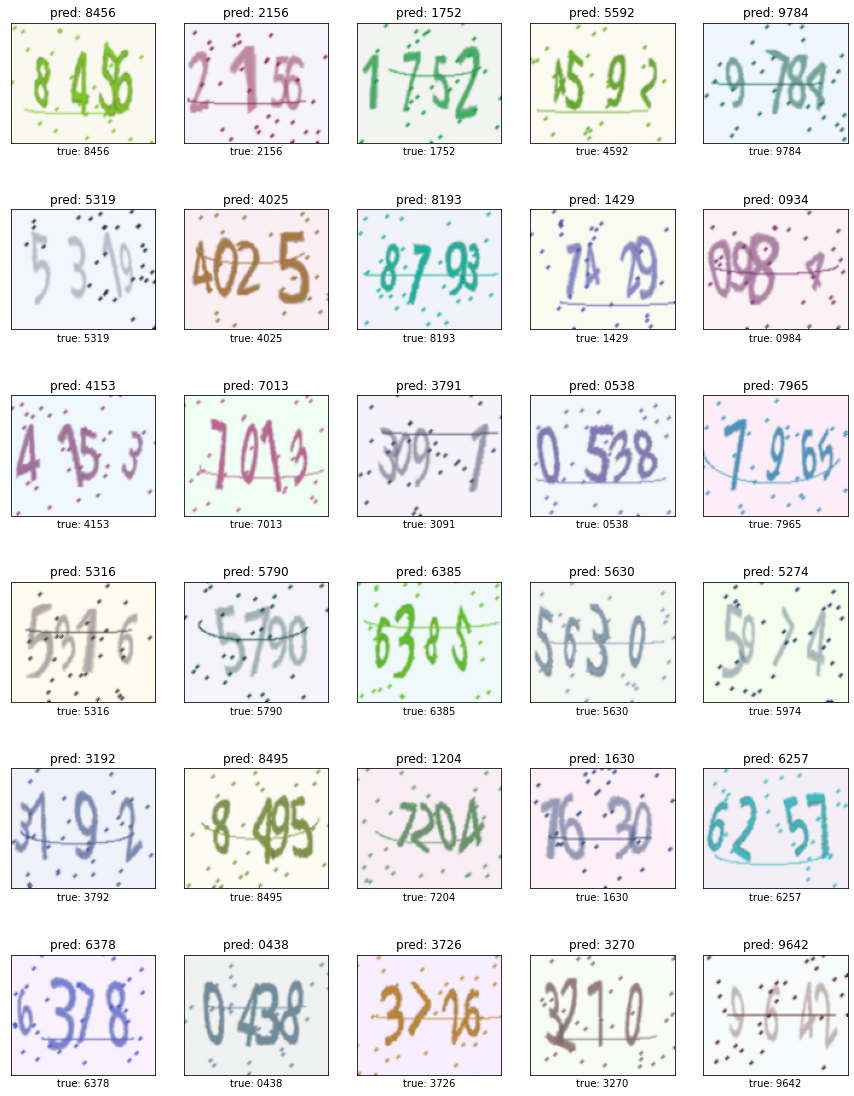

In [59]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: {}'.format(
        ''.join(map(str, y_pred[img_idx].numpy()))))
    ax.set_xlabel('true: {}'.format(
        ''.join(map(str, y_true[img_idx].numpy()))))
    ax.set_xticks([])
    ax.set_yticks([])